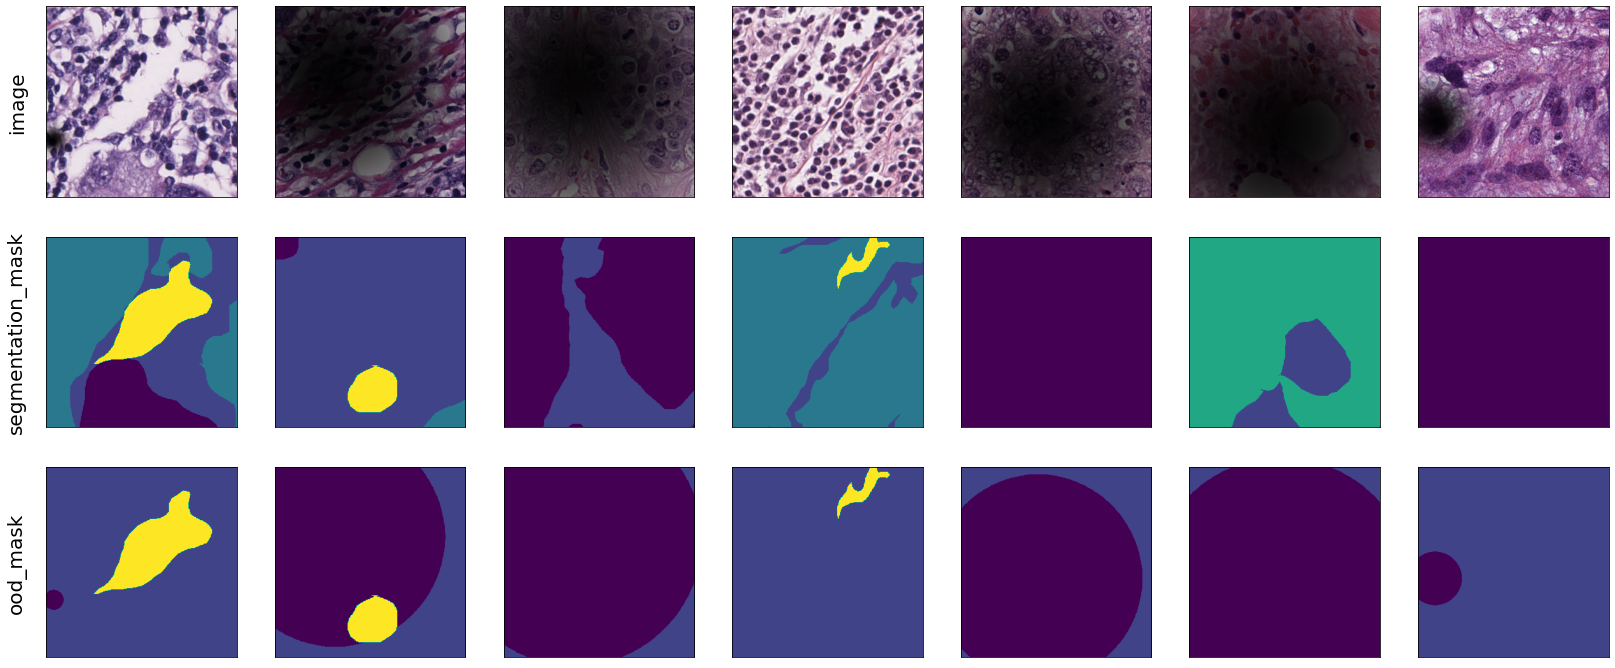

OOD Evaluation:   0%|          | 0/134 [00:00<?, ?it/s]c:\Users\jstieber\AppData\Local\conda\conda\envs\ssl4uc\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
OOD Evaluation: 100%|██████████| 134/134 [01:38<00:00,  1.36it/s]


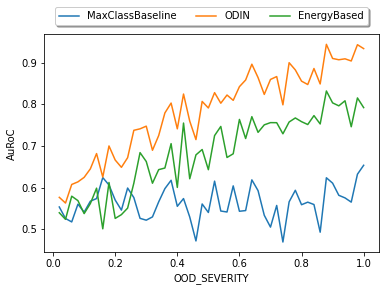

Name                             AUC
--------------------------  --------
MaxClassBaseline no params  0.564756
ODIN temp: 2, noise: 0.004  0.739579
EnergyBased temp: 1         0.648461


In [3]:
from froodo.quickstart import *


# init network
net = SegmentationModel().load()

# create dataset adapter
adapter = BCSS_Adapted_Cropped_Resized_Datasets().test

# choose metrics
metrics = [
    OODAuRoC(bin_by='OOD_SEVERITY', num_bins=50),
    OODAuRoC(),
]

# choose post-hoc OOD methods
methods = [MaxClassBaseline(), ODIN(), EnergyBased()]

# create experiment component
experiment = AugmentationOODEvaluationComponent(
    data_adapter=adapter,
    augmentation=SampledAugmentation(DarkSpotsAugmentation()),
    model=net,
    metrics=metrics,
    methods=methods,
    seed=4321,
)

# run experiment
experiment()